In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# Verify GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Define the paths to your dataset files
data_files = {
    'train': 'smart_contract_train.csv',
    'val': 'smart_contract_val.csv',
    'test': 'smart_contract_test.csv'
}

# Load the dataset
datasets = load_dataset('csv', data_files=data_files)

# Rename the 'vulnerable' column to 'labels'
datasets = datasets.rename_column('vulnerable', 'labels')

# Ensure the 'labels' column is of type int
datasets = datasets.map(lambda example: {'labels': int(example['labels'])})

# Initialize the tokenizer for CodeBERT
tokenizer = AutoTokenizer.from_pretrained('microsoft/graphcodebert-base')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['code'], padding='max_length', truncation=True, max_length=512)

# Apply tokenization to the datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Set the format for PyTorch
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load the pre-trained CodeBERT model with a classification head
model = AutoModelForSequenceClassification.from_pretrained('microsoft/graphcodebert-base', num_labels=2)

# Move the model to the appropriate device
model.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to = "none",
    no_cuda=not torch.cuda.is_available(),  # Disable CUDA if not available
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
)

# Fine-tune the model
trainer.train()

# Evaluate the model
trainer.evaluate()

Training on: cuda


Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.331845
2,No log,0.349979
3,No log,0.370606
4,No log,0.458788
5,No log,0.566240
6,No log,0.761329
7,0.278900,0.864190
8,0.278900,1.115772
9,0.278900,1.031402
10,0.278900,1.006786


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

{'eval_loss': 0.33184465765953064,
 'eval_runtime': 4.7282,
 'eval_samples_per_second': 59.431,
 'eval_steps_per_second': 3.807,
 'epoch': 10.0}

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


                precision    recall  f1-score   support

Not Vulnerable       0.85      0.83      0.84       148
    Vulnerable       0.81      0.84      0.83       130

      accuracy                           0.83       278
     macro avg       0.83      0.83      0.83       278
  weighted avg       0.84      0.83      0.83       278



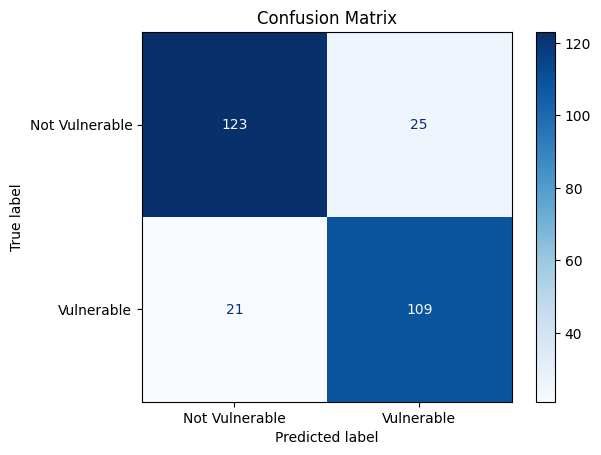

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make predictions
predictions = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Generate the classification report
report = classification_report(true_labels, preds, target_names=['Not Vulnerable', 'Vulnerable'])
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Vulnerable', 'Vulnerable'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the directory where the model and tokenizer will be saved
save_directory = "./graphcodebert"

# Save the fine-tuned model
trainer.save_model(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)